In this project we will 
- analyze a gps dataset 
- try to infer some ideas mainly from the coordinates (latitude, longitude) of the data. 
- do some explanatory data analysis by filtering and grouping the data
- look for some patterns in different time frames.
- start analizing subject of interest from the longer time frames and follow by the shorter time frames 
![location](/images/location.jpg)

<!-- TEASER_END -->

- work on a transformed dataset thus the coordinate values here are not real.

Lets first setup our notebook and get to know the dataset

In [39]:
# Notebook Setup
# import all modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
% matplotlib inline

Lets load the data into a pandas DataFrame by using `parse_dates` parameters to read the time data as pandas 'datetime' type and assign it as the index column.

In [40]:
gps_data=pd.read_csv("gps_data.csv", parse_dates=["timestamp"], index_col="timestamp")

# Print the first five rows
gps_data.head()

utc_time_sec  accuracy  longitude   latitude
timestamp                                                        
2015-03-01 07:16:39    1425190599    10.000  69.979205  20.687428
2015-03-01 07:17:12    1425190632    29.000  69.979196  20.687460
2015-03-01 07:17:25    1425190645    33.000  69.979229  20.687334
2015-03-01 07:18:19    1425190699    25.000  69.979197  20.687459
2015-03-01 07:18:25    1425190705    17.677  69.979197  20.687459

In [41]:
# Print the last 5 rows
gps_data.tail()

utc_time_sec   accuracy  longitude   latitude
timestamp                                                         
2015-03-31 21:10:27    1427829027  27.000000  69.979130  20.687346
2015-03-31 21:15:12    1427829312  30.756001  69.979147  20.687331
2015-03-31 21:19:57    1427829597  25.000000  69.979130  20.687346
2015-03-31 21:24:42    1427829882  35.000000  69.979144  20.687332
2015-03-31 21:29:27    1427830167  40.000000  69.979130  20.687344

As we see in the head and the tail of dataset we have a 30-day-long time series data with the columns below:

- `utc_time_sec`: Shows the number of seconds that have elapsed since January 1, 1970
- `accuracy`: We can read the accuracy values as "with high probability, the displayed location coordinates are within accuracy value distance (meters) of the GPS receiver" . For instance if the accuracy is 50, it means with a certain confidence level the GPS receiver is within 50 meters distance from the given coordinates
- `longitude` and `latitude` are the coordinate components

#### Inspect the dataset
With the `.info()` and `.describe()` methods we get additional details about the dataset

In [42]:
gps_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20266 entries, 2015-03-01 07:16:39 to 2015-03-31 21:29:27
Data columns (total 4 columns):
utc_time_sec    20266 non-null int64
accuracy        20266 non-null float64
longitude       20266 non-null float64
latitude        20266 non-null float64
dtypes: float64(3), int64(1)
memory usage: 791.6 KB


As all the columns have the same non-null values there is no `NaN` values in the dataset.

In [43]:
gps_data.describe()

utc_time_sec      accuracy     longitude      latitude
count  2.026600e+04  20266.000000  20266.000000  20266.000000
mean   1.426281e+09    110.244727     69.885160     20.505590
std    8.082751e+05    264.955405      0.108638      0.205766
min    1.425191e+09      6.000000     69.737213     20.244196
25%    1.425570e+09     30.000000     69.749819     20.254997
50%    1.426051e+09     33.011000     69.959465     20.625682
75%    1.426932e+09     57.000000     69.979194     20.687362
max    1.427830e+09   2829.000000     70.132735     20.994541

When we check the `mean` and the `median` (50th percentile) values of the accuracy column we see that they are quite different. The outliers (extreme values) move the mean away from the median. <br>

Let's look at the distribution of the accuracy column and see the outliers.

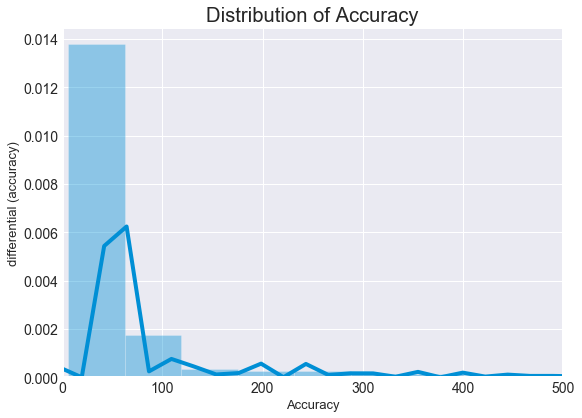

In [44]:
sns.set_style("darkgrid")
fig, ax=plt.subplots(figsize=(8,6))
sns.distplot(gps_data["accuracy"])

ax.set_xlabel("Accuracy", fontsize=13)
ax.set_ylabel("differential (accuracy)", fontsize=13)
ax.set_title("Distribution of Accuracy");
ax.set_xlim(left=0, right=500);

Generally environmental factors such as dense trees, steep hillsides, tall buildings, or even heavy cloud cover can impact the travel of the GPS signal between the gps device and the satellites. Under these conditions data accuracy can decrease. We should discard the data with poor accuracy.

In [45]:
# Remove the rows with accuracy level > 57 m
# The values out of the third quartile
gps_data= gps_data[gps_data["accuracy"]< 57]

# See the size and other parameters of the dataset after removal
gps_data.info()
gps_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15197 entries, 2015-03-01 07:16:39 to 2015-03-31 21:29:27
Data columns (total 4 columns):
utc_time_sec    15197 non-null int64
accuracy        15197 non-null float64
longitude       15197 non-null float64
latitude        15197 non-null float64
dtypes: float64(3), int64(1)
memory usage: 593.6 KB


utc_time_sec      accuracy     longitude      latitude
count  1.519700e+04  15197.000000  15197.000000  15197.000000
mean   1.426308e+09     32.530246     69.886460     20.508920
std    8.155825e+05      9.308392      0.109061      0.206744
min    1.425191e+09      6.000000     69.745429     20.244196
25%    1.425625e+09     27.000000     69.749820     20.254998
50%    1.426053e+09     30.000000     69.973362     20.659323
75%    1.426947e+09     37.500000     69.979196     20.687379
max    1.427830e+09     56.988998     70.130281     20.929037

As we can see now mean and median of the accuracy column is very close to each other

# Feature Creation
In this part, two new features are created:
- `time_difference_sec`: Time difference in seconds between two succesive data points
- `distance_km`: Distance in kilometers between two succesive location

## Time intervals are not uniform
Let's first look at the time intervals. We observe that the time difference between successive data points are not equal. To see the time differences between successive data points we create a new column which shows the the differences in seconds: `time_difference_sec`

In [46]:
# Add a column showing the time differences between two successive data points in seconds
gps_data["time_difference_sec"]=gps_data["utc_time_sec"].diff()

# Print the details of time_difference column with .describe() method 
print(gps_data.time_difference_sec.describe())

# Print the head 
gps_data.head(3)

count     15196.000000
mean        173.701500
std        2677.978126
min           2.000000
25%          28.000000
50%          31.000000
75%          61.000000
max      140589.000000
Name: time_difference_sec, dtype: float64


utc_time_sec  accuracy  longitude   latitude  \
timestamp                                                           
2015-03-01 07:16:39    1425190599      10.0  69.979205  20.687428   
2015-03-01 07:17:12    1425190632      29.0  69.979196  20.687460   
2015-03-01 07:17:25    1425190645      33.0  69.979229  20.687334   

                     time_difference_sec  
timestamp                                 
2015-03-01 07:16:39                  NaN  
2015-03-01 07:17:12                 33.0  
2015-03-01 07:17:25                 13.0

Since the number of intervals between n succesive points is n-1 the first value of the `time_difference_sec` is `"NaN"`

## Time differences on chart
Let's see the distribution of the time intervals between two successive data records

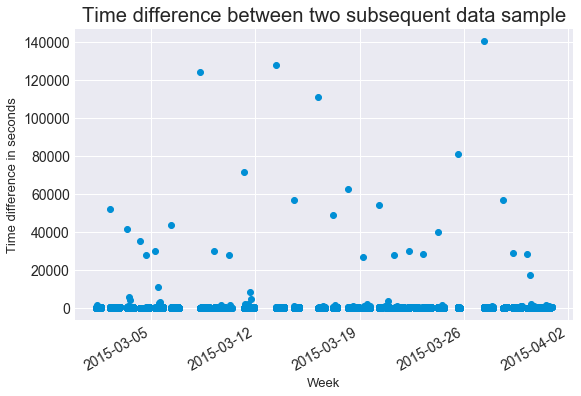

In [47]:
fig, ax=plt.subplots(figsize=(8,6))
gps_data.time_difference_sec.plot(marker="o", linewidth=0)

ax.set_xlabel("Week", fontsize=13)
ax.set_ylabel("Time difference in seconds", fontsize=13)
ax.set_title("Time difference between two subsequent data sample");

As we see on the chart there are some extreme time gaps. This happens due to the connection lost. During this gaps either the device is turned off or gps signal is lost due to the environmental factors.

## Distribution of time gaps

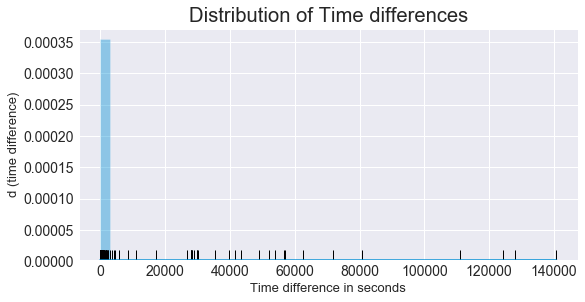

In [48]:
fig, ax=plt.subplots(figsize=(8,4))
sns.distplot(gps_data["time_difference_sec"].dropna(), 
                 rug=True, 
                 rug_kws={"color":"black"})

ax.set_xlabel("Time difference in seconds", fontsize=13)
ax.set_ylabel("d (time difference)", fontsize=13);
ax.set_title("Distribution of Time differences");
#ax.set_xlim(0, 4000);

## Plot of the coordinates of gps_data
It is time to plot the coordinates, latitude and longitude values  and see how it is scattered during all the period.

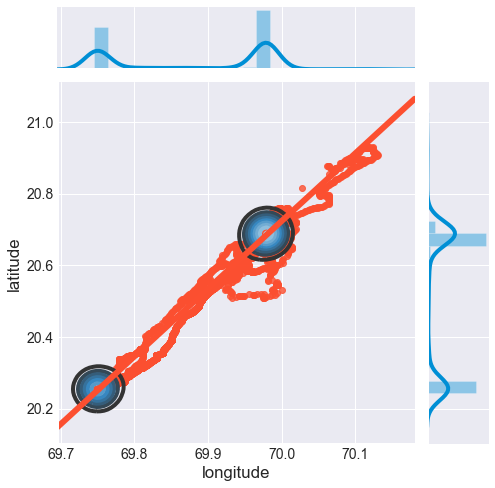

In [49]:
# Display the joint distribution of longitudes and lattitudes
g= sns.JointGrid(x="longitude", 
                 y= "latitude", 
                 data=gps_data, 
                 height=7)

g= g.plot_joint(sns.kdeplot, cmap="Blues_d")
g= g.plot(sns.regplot, sns.distplot)

We can clearly see from the plot that they are concentrated in two points. The basic idea here is that the user of the device spends her/his time mainly in two spots during the data period. Most likely, one of the two points is the house and the other is the work place. We will try to look in the details of this.

## Distances: Euclidean vs Spherical
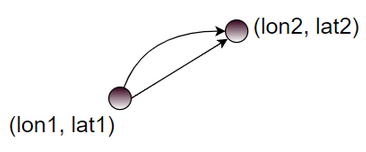

Since the earth is spherical the distance between two cordinates on the surfcace is different than Euclidean distance, as seen in the picture. To calculate the distance from the latitude and longitute there are several methods like [Haversine](https://en.wikipedia.org/wiki/Haversine_formula) or [Vincenty](https://en.wikipedia.org/wiki/Vincenty%27s_formulae) or the other methods. We can use [geopy.distance](https://geopy.readthedocs.io/en/stable/index.html?highlight=great_circle#module-geopy.distance) function here. 

In [50]:
# See how the distance function works

# Two coordinate samples with 0.1 change in lattitudes
coords1 = (20.0, 70)
coords2 = (20.1, 70)

# Pass the coordinates to the distance function and 
# use the `.km` attribute to get the distance in kilometer
print("When the other component is constant")
print("0.1 change in latitude corresponds", geopy.distance.distance(coords1, coords2).km, " km change")

# Another coordinate samples with 0.1 change in longitude
coords2 = (20, 70)
coords3 = (20, 70.1)

print( "0.1 change in longitude corresponds", geopy.distance.distance(coords2, coords3).km, "km change")

When the other component is constant
0.1 change in latitude corresponds 11.070491302727412  km change
0.1 change in longitude corresponds 10.46470847561311 km change


## Subsequent Distances

Having seen how the `distance` function works we can use it to get the distances between two subsequent data points.

In [51]:
# Represent a location as a latitude and longitude tuple and
# create the locations list whose elements are the tuples consist of latitude and longitude values
locations=list(zip(gps_data.latitude, gps_data.longitude))

# Make a list of succesive distances in kms
# by using list comprehensive method and geopy.distance.distance function
distance_lst=[geopy.distance.distance(locations[i-1], locations[i]).km for i in range(1, len(locations))]

# Print the first 3 elements of the distance_lst
distance_lst[:3]

[0.003621872383733491, 0.014308385103896632, 0.014267680909438382]

### Create the `distance_km` column
We have created a list of distances covered between two data records. Now we add a distance column to our dataframe

In [52]:
# Since the number of intervals between n succesive points is n-1
# We need to insert a 0 (zero) in the first position of the list in order to 
# match the index size of the gps_data dataframe
distance_lst.insert(0, 0)

# Convert the distance list to an array 
distance_ary=np.array(distance_lst)

# Round the distance values to 4 decimals
distance_ary=np.round(distance_ary, 4)

# Add a new column of distances in kms: distance_km
gps_data["distance_km"]= distance_ary

# See the head of the new data frame
gps_data.head(3)

utc_time_sec  accuracy  longitude   latitude  \
timestamp                                                           
2015-03-01 07:16:39    1425190599      10.0  69.979205  20.687428   
2015-03-01 07:17:12    1425190632      29.0  69.979196  20.687460   
2015-03-01 07:17:25    1425190645      33.0  69.979229  20.687334   

                     time_difference_sec  distance_km  
timestamp                                              
2015-03-01 07:16:39                  NaN       0.0000  
2015-03-01 07:17:12                 33.0       0.0036  
2015-03-01 07:17:25                 13.0       0.0143

# Grouping for different time frames


Time series data can give us ideas about the patterns in different time frames. 

We can observe the patterns 
- by extracting the time of interest from the timestamp and 
- by grouping of the relevant metric column(s) by the time element and
- applying an aggregation method

In this section we try to get some inference by groupping the data in different time frames.<br>
We start from the largest time frame and afterwards analyze the shorter ones. <br>

Since our gps dataset's entire time interval is one month, we first start working on daily data groups and than continue with hourly data groups.

## Splitting the data
Before going deeper in grouping, it would be a good practice to split the data into two part as **weekdays** and **weekend**. 

We know that in general for many people the habits, schedules etc are quite different in these two periods. <br>
For instance, assume that we wake up around 6am during weekdays and around 9am at weekends (bimodal), without splitting the data we can calculate the average wakeup time as aproximately 7am. However this is not a good interpretation because we never wake up at 7am during all the period. 

If data contains different patterns in different time frames observing data in separatly give us more robust results. 

So let's first split our data as `weekdays` and `weekend`

In [53]:
# Excrat the weekdays from the gps_data: weekdays
weekdays=gps_data[gps_data.index.weekday < 5]

# Excrat the weekends from the gps_data: weekend
weekend=gps_data[gps_data.index.weekday >= 5]

# Plotting Functions
In this project we do ploting repeatedly so it would be more efficient to define ploting functions instead of writing the scripts again each time

## `bar_plot` function

In [54]:
# Define the barplot function: bar_plot
def bar_plot(df, label_x, label_y, str_title):
    '''Takes a dataframe and three strings: label of x-axis, label of y-axis and title
        returns a bar plot'''
    plt.style.use('fivethirtyeight')
    fig, ax=plt.subplots()
    ax= df.plot(kind= "bar", 
                figsize=(10,5), 
                rot=70,
                fontsize=11)        
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.set_title(str_title)
    plt.show()

## Daily  `number of data records`  

Having splitted the data into different time frames, now we can look into daily data recording patterns. <br>
Let's count the number of data records in weekdays and weekends.

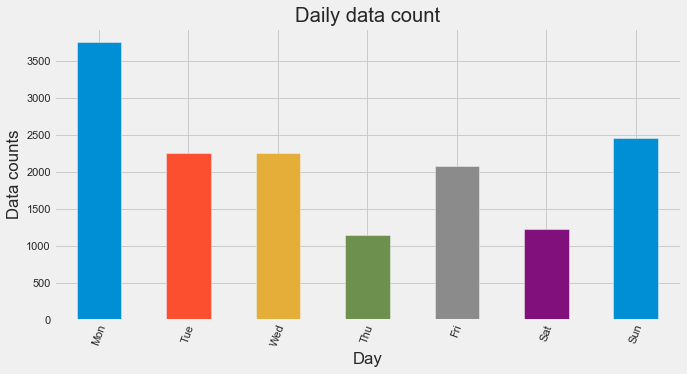

In [55]:
# Count the daily data records in weekdays: daily_count
# Groupby the gps_data daily by extracting the "day" from the datetime index and 
# count any of the column (without NaN values)
daily_weekdays_count= gps_data.groupby(gps_data.index.dayofweek).accuracy.count()

# Set the index with the names of days
daily_weekdays_count.index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', "Sat", "Sun"]

labelx="Day"
labely= "Data counts"
title="Daily data count"
bar_plot(daily_weekdays_count, labelx, labely, title)

## Hourly `number of data records`  
Observing data recordings based on the hours of the day can give some insight about our dataset. <br>
Now our time frame is 24 hours. Each bar represents an hour of the days so it is better to use splitted datasets.<br>  Here we start by weekdays

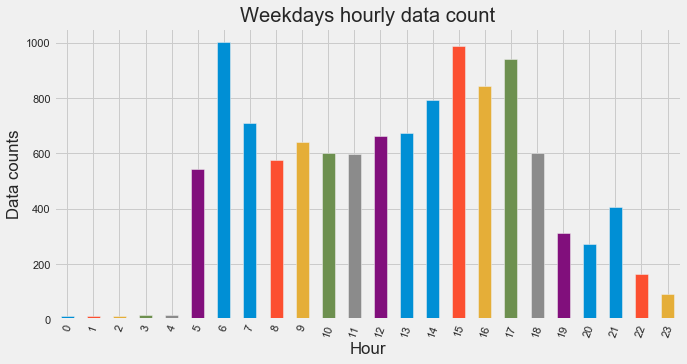

In [56]:
# Count the hourly data records in weekdays: hourly_weekdays_count
# Groupby the weekdays hourly by extracting the "hour" from the datetime index and 
# count any of the column (without NaN values)
hourly_weekdays_count= weekdays.groupby(weekdays.index.hour).accuracy.count()

# Set the index with the keys of the group object, here hours
hourly_weekdays_count.index= hourly_weekdays_count.keys()

labelx="Hour"
labely= "Data counts"
title="Weekdays hourly data count"
bar_plot(hourly_weekdays_count, labelx, labely, title)

In the above chart, to calculate one of the bars, say 10am bar, we sum all the data records of the `weekdays` between `10-11 am during all the weekdays` (excluding weekends).

Lets try to interpret the chart. 
- At fist glance it is evident that during the night especially between 0-5 am, we could not get much data. 
- Also after 19h the number of data records decreasing. 
- This can be related with the device usage habits. 
- Maybe the user sometimes turn off the device after 19h and generally after midnight during sleep hours. Or this can be an issue of signal lost that is related with the place where the user spends the time after 19, most likely the home. 

Now we plot the same chart for the weekends.

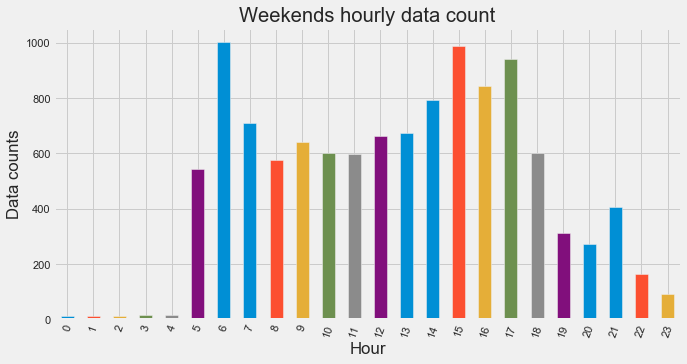

In [57]:
# Count the hourly data records in weekends: hourly_weekends_count
# Groupby the weekends hourly by extracting the "hour" from the datetime index and 
# count any of the column (without NaN values)
hourly_weekends_count= weekend.groupby(weekend.index.hour).accuracy.count()

# Set the index with the keys of the group object, here hours
hourly_weekends_count.index= hourly_weekends_count.keys()

labelx="Hour"
labely= "Data counts"
title="Weekends hourly data count"
bar_plot(hourly_weekdays_count, labelx, labely, title)

We can observe a slight difference between weekdays and weeekend chart especially in the early morning and late night parts

At this point we can process `weekdays` partially in different intervals like `morning, daytime, evening` in order to get additional information about the data records in shorter time frames.

We will do this just for the weekdays data in order to keep this notebook shorter but it can be easily applied on the weekend data in the same way as weekdays. 

## Number of data recording days

In [58]:
# Slice the period 0-5 hours from the weekdays df: night_weekdays
night_weekdays=weekdays[(weekdays.index.hour>=0) & (weekdays.index.hour<5)]
                        
# Days in which we get data during 0-5 hours
# Extract the unique days by .unique() method 
days0_5=night_weekdays.index.day.unique()

# Print all the weekdays first
print('All the weekdays of the dataset:', "\n", f'{set(weekdays.index.day)}')
print(f'({len(set(weekdays.index.day))} days)', "\n")

# Print only the days we record data
print("Data recording days during 0h-5h:", "\n", list(days0_5))

All the weekdays of the dataset: 
 {2, 3, 4, 5, 6, 9, 10, 11, 13, 16, 17, 18, 19, 20, 23, 24, 25, 27, 30, 31}
(20 days) 

Data recording days during 0h-5h: 
 [31]


The result tells us that we could get data only for one day, 31st day. Now same process for the daytimes 

In [59]:
# Slice the period 5-19 hours from the weekdays df: night_weekdays
daytime_weekdays=weekdays[(weekdays.index.hour>=5) & (weekdays.index.hour<19)]

# Days in which we get data during 5-19 hours
days5_19= daytime_weekdays.index.day.unique()

# Print only the days we record data
print("Data recording days during 5h-19h:", "\n", list(days5_19))
print(f'({len(list(days5_19))} days)')

Data recording days during 5h-19h: 
 [2, 3, 4, 5, 6, 9, 10, 11, 13, 16, 17, 18, 19, 20, 23, 24, 25, 27, 30, 31]
(20 days)


We have data for all the weekdays daytime. Same process for the evening period

In [60]:
# Slice the period 19-24 hours from the weekdays df: night_weekdays
evening_weekdays=weekdays[(weekdays.index.hour>=19) & (weekdays.index.hour<24)]

# Days in which we get data during 19_24 hours
days19_24= evening_weekdays.index.day.unique()

# Print only the days data is recorded
print("Data recording days during 19_24:", "\n", list(days19_24))
print(f'({len(list(days19_24))} days)')

Data recording days during 19_24: 
 [2, 3, 4, 5, 6, 9, 11, 13, 18, 20, 27, 30, 31]
(13 days)


The numbers of data receiving days better explains the "Weekdays hourly data count" chart.

# `Movement` in weekdays
After data count, we can look for the movement patterns. <br>
We are interested in how the user changes places.<br>
Is there any pattern in his/her movements?

As you know we calculated the distance between two positions in two subsequent data points and created the `distance_km` column.

Here our approach is 
- to sum the distances to find the total movement in a time frame and
- divide it into the number of the number of that time frame to find the average movent. 

As usual we from the larger time frame i.e daily 

##  `Average Movement` based on the `days of the week`

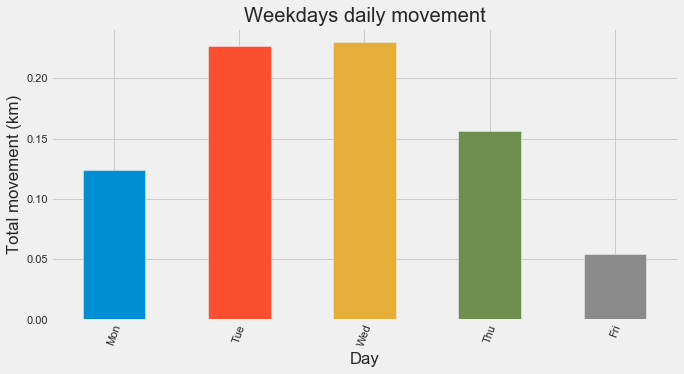

In [61]:
# Find the average daily distance_km values in weekdays df: daily_movement
# Groupby the the distance_km column values daily and aggregate by mean
daily_movement=weekdays.groupby(weekdays.index.dayofweek).distance_km.mean()

# Set the index by the names of the weekdays
daily_movement.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

# Plot the chart
labelx="Day"
labely= "Total movement (km)"
title="Weekdays daily movement"
bar_plot(daily_movement, labelx, labely, title)

In the chart above, to calculate one of the bars, say Tue bar, 
- we sum all the distance changes of the user during all the tuesdays and 
- divide it into the number of all the tuesdays over all the dataset.

It is easily seen that on fridays the user changes place significantly less than other weekdays. <br>
What would be the reason? 

Let's plot the coordinates based on a day of the week to see if there is any answer for less movement on fridays.

## Define a plot function: `group_plot_coord`

First we need to define a plot function to plot the coordinates of shorter time frames subsequently so whenever we need to plot subplots, instead of writing the scripts again we can call the function.

Here is the steps:
- First we group the dataframe by the relevant time frame then
- plot the coordinates of each group on the entire coordinates of the dataset 
- by iterating over the groupby object

In [62]:
def group_plot_coord(groupby_obj, title_func):
    '''Takes a groupby object and a function (to create the titles of the subplots)
    returns a subplot for each of the group'''
    
    # Use the 'fivethirtyeight' style
    plt.style.context('fivethirtyeight')
    # associate the row number argument in plt.subplots with groupby obj
    row_number=int(len(groupby_obj)/2)+1
    
    # Create figure and axes
    # We fix the number of column of the figure by ncols=2 and
    # Let the row_number change by the size of the groupby object
    # We will delete the last empty subplots at the end
    fig, axes = plt.subplots(nrows=row_number, ncols=2,
                             figsize=(16, 16),
                             sharex=True, 
                             sharey=True)

    # Flatten the axes and convert into a list in order to be able to pop the elements one by one
    axes_lst=list(axes.flatten())

    # Iterate over the groups in the groupby object
    for group_name, group in groupby_obj:
        # Assign the first ax in the ax_lst as current ax
        ax=axes_lst.pop(0)
        # Create the scatter plot of latitudes and longitudes of entire gps_data df
        ax.scatter(gps_data["longitude"], gps_data["latitude"],
                   color=".5",
                   edgecolor="white",
                   s=50)
        # Plot the lattidues and longitudes of each group on the same ax
        group.plot(x="longitude", y="latitude", 
                   ax=ax, 
                   kind="scatter", 
                   legend=True,
                   label=group_name, 
                   s=60, 
                   c="r",
                  edgecolor="white")
        # Set the title of each subplot
        ax.set_title(title_func(group_name))
        plt.show()
    
    # Use matplotlib .remove() method to delete the last empty subplot
    [ax.remove() for ax in axes_lst];

## Coordinates plot based on the weekdays 

- First we group the `weekdays` dataframe by days of week
- Then we iterate over the groups, in this case the days and
- plot the coordinates of each day over the coordinates of entire dataset

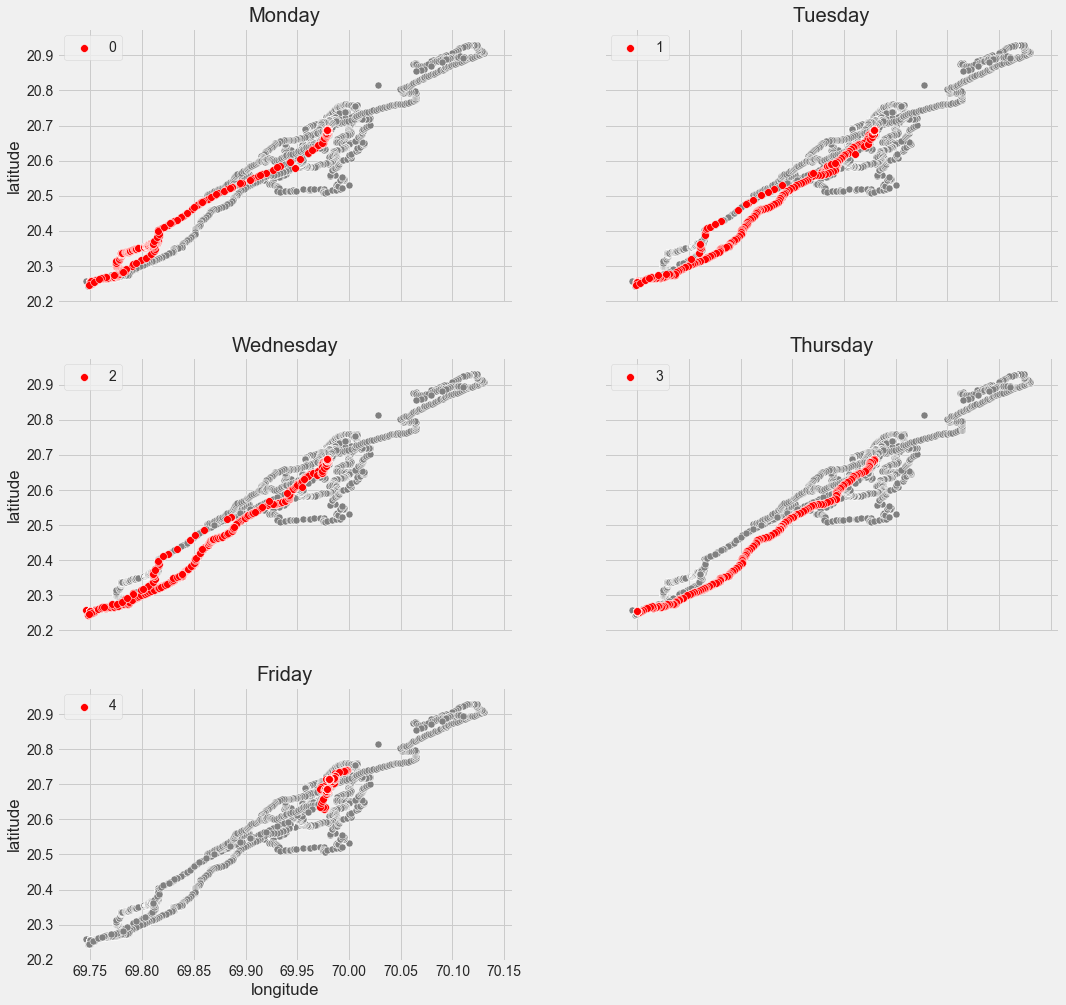

In [63]:
# Groupby the weekdays dataframe based on days of the week: daily_group
daily_groups=weekdays.groupby(weekdays.index.dayofweek)

# Create a dictionary of day names in order to use for the titles of subplots
day_dict={0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday"}

# define the title func:title_func
def daily_title(name):
    return day_dict[name]
# Plot the coordinates of all the weekdays
group_plot_coord(daily_groups, daily_title)

In the above charts daily subplots give us some more information about the coordinates distribution during the weekdays.<br>
Here we notice that the movement on friday is different than the other days. On fridays the user does not follow a track like the other weekdays.<br>

We can make a guess that the user going to work monday to thursday regularly but on fridays he/she works from home or another.<br>
We can also think that it is an off day but the coordinates are not dispersed so the user stay around one spot most likely the home  

Now lets also look at the distribution of the daily coordinates. 

Like we did with other charts first we need to define a distribution function for reusebility.

## Define a joint distribution plot function: `full_joint_plot`

In [64]:
# Display the joint distribution of longitudes and lattitudes
def full_joint_plot(df, title_str):
    '''Takes a dataframe and title string and returns a joint distribution of the coordinates'''
    sns.axes_style("darkgrid")
    g= sns.JointGrid(x="longitude", 
                     y= "latitude", 
                     data=df, 
                     height=7)
    g.plot_joint(sns.kdeplot, cmap="Blues_d")
    sns.kdeplot(df["longitude"], ax=g.ax_marg_x, legend=False)
    sns.kdeplot(df["latitude"], ax=g.ax_marg_y, vertical=True, legend=False)
    g.ax_joint.plot(df["longitude"], df["latitude"], "o", ms=5)
    g.fig.suptitle(title_str, x=0.4, y=0.81);

## Coordinates distribution of `monday-to_thursday`
Since we noticed that the movement pattern is different on fridays than the days from monday to thursday, it is better to visualize the distributions separately. 

Let's first look at the distribution of the `monday_to_fridays`

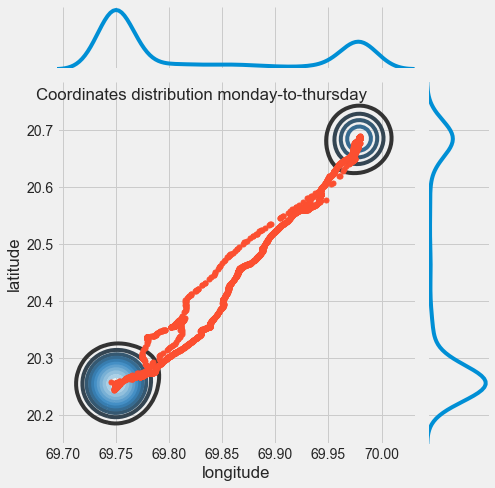

In [65]:
# Slice the rows of the day monday-to-thursday from gps_data: mon_to_thu
mon_to_thu= gps_data[gps_data.index.dayofweek < 4]
title_str="Coordinates distribution monday-to-thursday"
full_joint_plot(mon_to_thu, title_str)

## Coordinates distribution of `fridays`

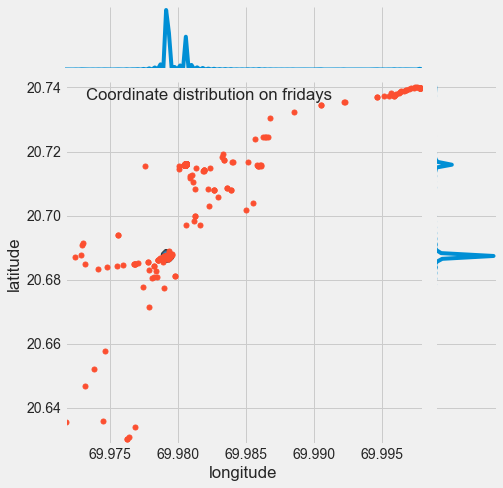

In [66]:
# Slice the rows on fridays from gps_data: fridays
fridays=gps_data[gps_data.index.dayofweek==4]

title_str="Coordinate distribution on fridays"
full_joint_plot(fridays, title_str)

Now we can continue our analyse of movement in the hourly time frame.

##  `Average movement` based on the ` hours of the days`
Here we try to stick to our approach and visualize the hourly average moment seperately for monday-to-thursday and for fridays periods.

#### Monday to thursday hourly movement

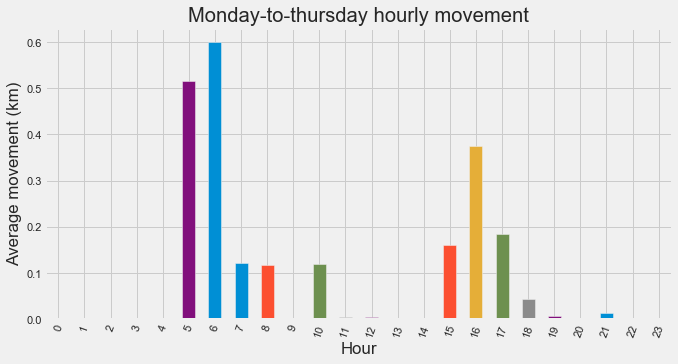

In [67]:
# Find the average hourly distance_km values in mon_to_thu df: hourly_movement1_4
# Groupby the the distance_km column values hourly and aggregate by mean
hourly_movement1_4=mon_to_thu.groupby(mon_to_thu.index.hour).distance_km.mean()

# Set the index by the keys of the group object, here hours
hourly_movement1_4.index = hourly_movement1_4.keys()

# Plot the chart
labelx="Hour"
labely= "Average movement (km)"
title="Monday-to-thursday hourly movement"
bar_plot(hourly_movement1_4, labelx, labely, title)

#### Fridays hourly movement

In [68]:
# drop the outlier
fridays=fridays.drop(pd.to_datetime("2015-03-20 07:21:58"))

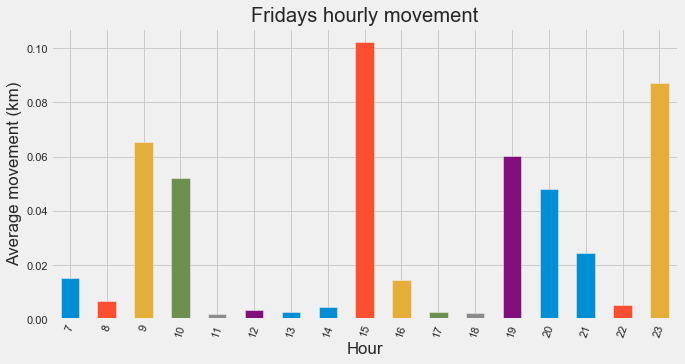

In [69]:
# Find the average hourly distance_km values in fridays df: hourly_movement4
# Groupby the the distance_km column values hourly and aggregate by mean
hourly_movement4=fridays.groupby(fridays.index.hour).distance_km.mean()

# Set the index by the keys of the group object, here hours
hourly_movement4.index = hourly_movement4.keys()

# Plot the chart
labelx="Hour"
labely= "Average movement (km)"
title="Fridays hourly movement"
bar_plot(hourly_movement4, labelx, labely, title)

## Hourly coordinates plot
To visualize the hourly movements lets plot the coordinates in hourly time frames. 

But first we need to split the `mon_to_thu` and `fridays` dataframes into 2: morning, afternoon.

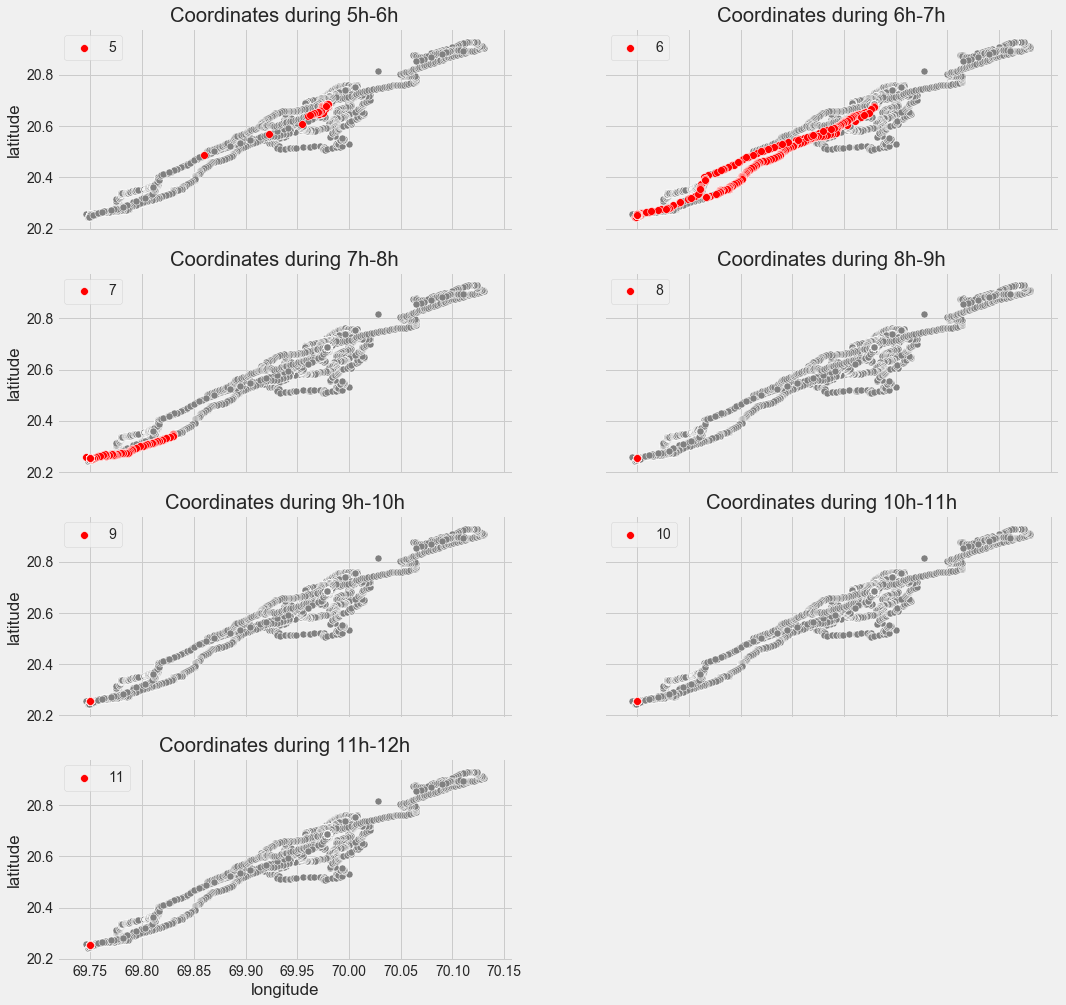

In [70]:
# Slice the morning times from mon_to_thu df
morning0_3=mon_to_thu[(mon_to_thu.index.hour>=5)& (mon_to_thu.index.hour<12)]

# Groupby the morning_weekdays hourly: hourly_morning
hourly_morning0_3=morning0_3.groupby(morning0_3.index.hour)

def hourly_title(name):
    return f'Coordinates during {name}h-{name+1}h'

group_plot_coord(hourly_morning0_3, hourly_title)

Distribution of the coordinates during different morning hours from monday to thursday support our first idea about the home and workplace. Generally the the positions are consantrated in 2 centers except from the chart of 6h-7h. Since the points connecting two centers we can conclude that device user commutes to work generally between 6h-7h, sometimes also later than 7h.

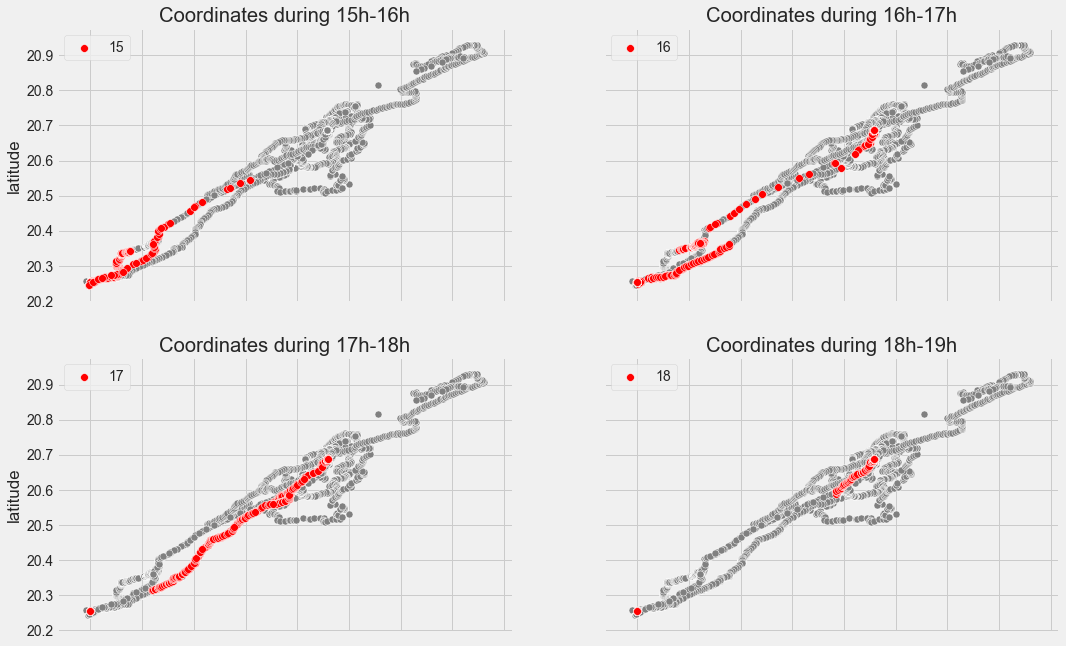

In [71]:
# Slice the morning times from mon_to_thu df
afternoon0_3=mon_to_thu[(mon_to_thu.index.hour>=15)& (mon_to_thu.index.hour<19)]

# Groupby the morning_weekdays hourly: hourly_morning
hourly_afternoon0_3=afternoon0_3.groupby(afternoon0_3.index.hour)

def hourly_title(name):
    return f'Coordinates during {name}h-{name+1}h'

group_plot_coord(hourly_afternoon0_3, hourly_title)

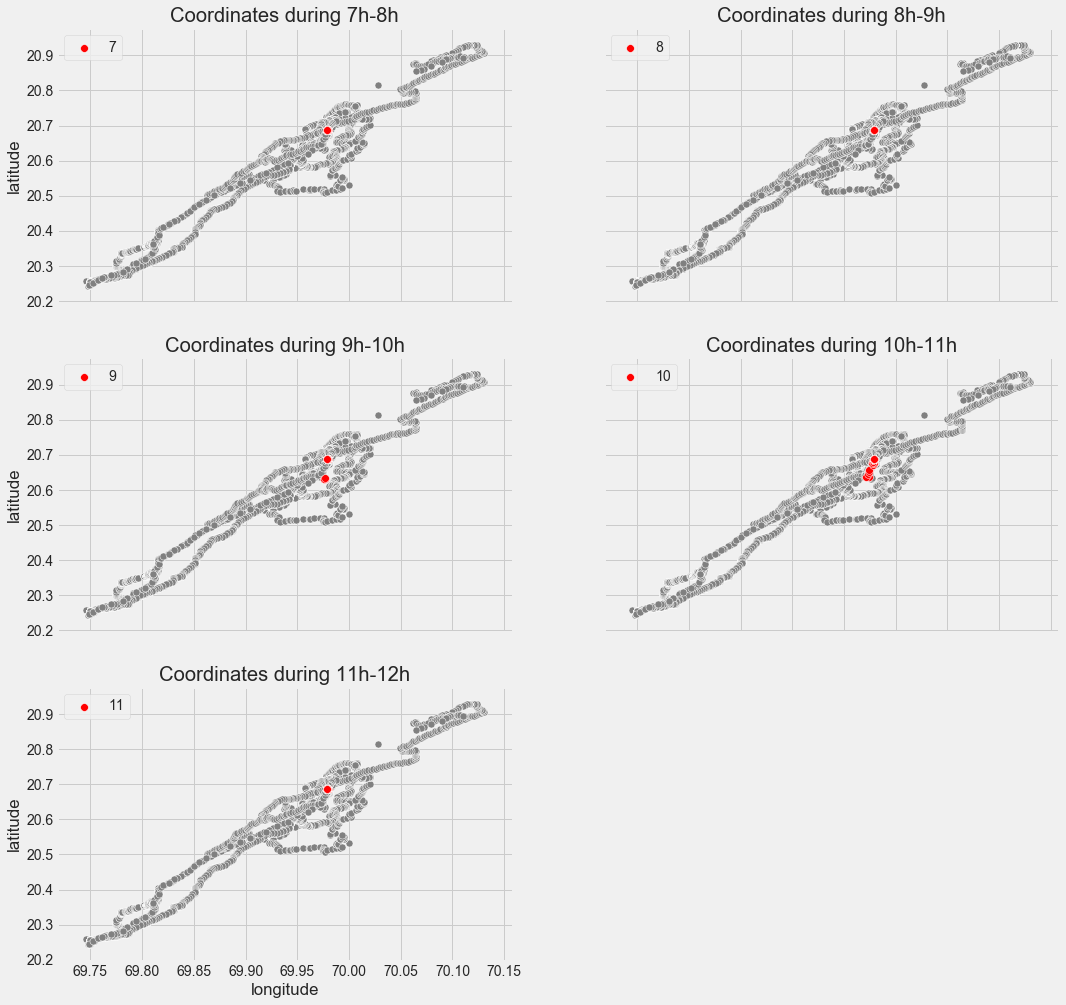

In [72]:
# Slice the morning times from fridays df
morning_fridays=fridays[(fridays.index.hour>=6)& (fridays.index.hour<12)]

# Groupby the morning_fridays hourly: hourly_morning_friday
hourly_morning_friday=morning_fridays.groupby(morning_fridays.index.hour)

def hourly_title(name):
    return f'Coordinates during {name}h-{name+1}h'

group_plot_coord(hourly_morning_friday, hourly_title)

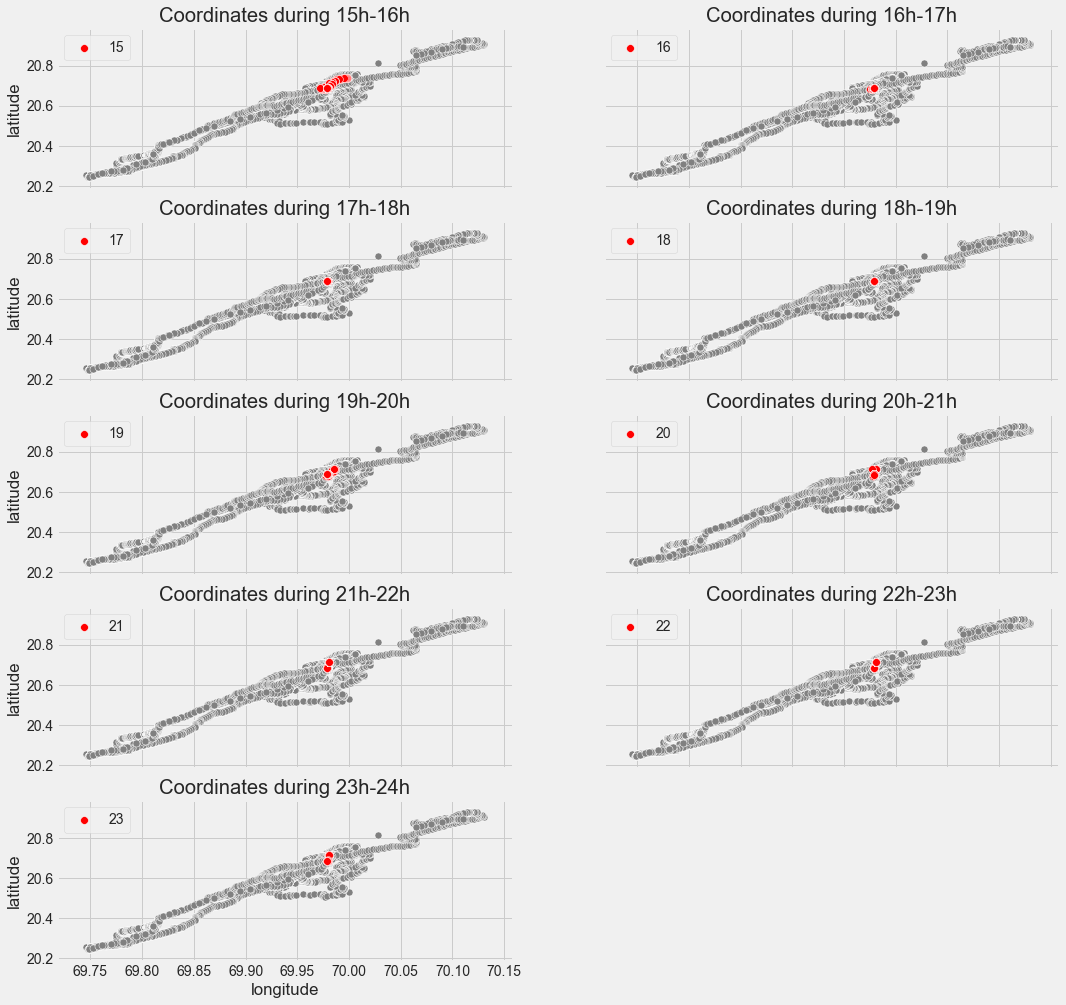

In [73]:
# Slice the morning times from fridays df
afternoon_fridays=fridays[(fridays.index.hour>=15)& (fridays.index.hour<24)]

# Groupby the morning_fridays hourly: hourly_morning_friday
hourly_afternoon_friday=afternoon_fridays.groupby(afternoon_fridays.index.hour)

def hourly_title(name):
    return f'Coordinates during {name}h-{name+1}h'

group_plot_coord(hourly_afternoon_friday, hourly_title)

## Distribution of `morning_weekdays` data
At this point looking at the distribution of the positions with kernel density estimate function for the morning, afternoon evening and night periods can give us more insights.

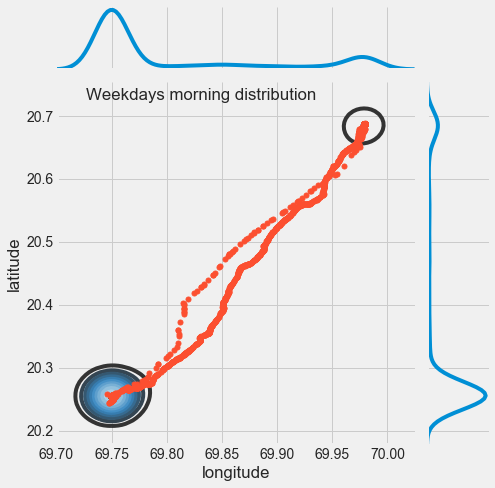

In [74]:
title= "Weekdays morning distribution"
full_joint_plot(morning0_3, title)

This chart is inline with the previous charts and explains clearly that user spends his weekdays mornings mostly in two centers. The density color highlights that more time is spent in one center (upper right) than the other.

## Distribution of `morning_fridays` data

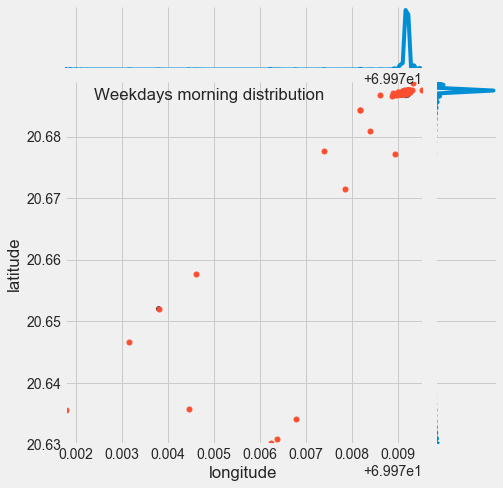

In [75]:
title= "Weekdays morning distribution"
full_joint_plot(morning_fridays, title)

## Heatmap of `average movement` and `hours of the day`
An heatmap also can be helpful to observe the patterns. They are handy to plot “rectangular data” such as matrixes especialy to visualize calculated values such as averages, counts and see if there are outstanding parts.

- Here we display the `hourly distances` covered by the user based on `all the days`. 
- To get get the color density of one of the unit of the heatmap, say (Tue, 5), 
    - we sum the distance changes beetween 5-6 am over all the tuesdays and 
    - To calculate the color density of the unit, the ratio of the distance on (Tue,5) over the total sum of all the distance changes over the all the data set. 
    - The darker means the higher amount as shown in the colorbar.

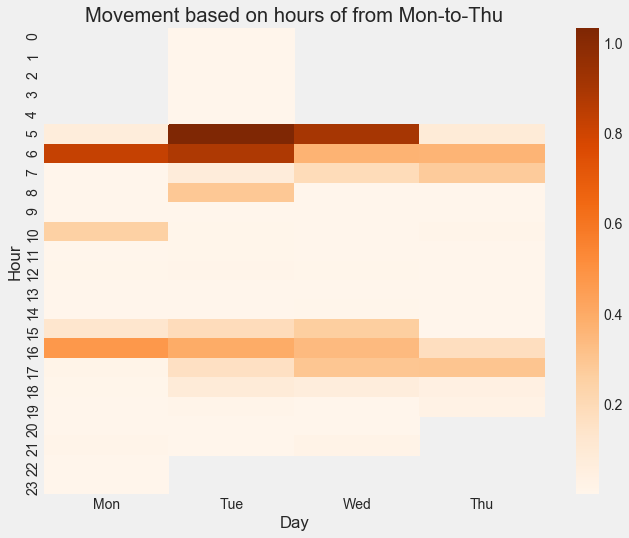

In [76]:
# Subset the gps_data df by just taking distance_km column: heatmap_df
# Since we will do summation and averaging we can replace the NaN values with 0 (zero)
heatmap_df=mon_to_thu[["distance_km"]]

# Add "day" column by extracting the day from the datetime index
heatmap_df["day"]= heatmap_df.index.dayofweek

# Add "hour" column by extracting the hour from the datetime index
heatmap_df["hour"]= heatmap_df.index.hour

# Drop the timestamp index
heatmap_df=heatmap_df.reset_index(drop=True)

# Because of the dublicated values we cannot pivot the dataframe directly for the heatmap
# First we need to create a pivot table
p_table = pd.pivot_table(heatmap_df, 
                       values='distance_km', 
                       index=['day', 'hour'], 
                       aggfunc=np.mean)

# Reset the indexes as columns
p_table=p_table.reset_index(level='hour').reset_index()

# Now we can create the pivot dataframe
heatmap_df= p_table.pivot(index="hour", 
                          columns="day", 
                          values="distance_km")

# Display the heatmap
fig, ax = plt.subplots(figsize=(10, 8)) 
ax = sns.heatmap(heatmap_df,
                 cmap= 'Oranges', 
                 xticklabels=["Mon", "Tue", "Wed", "Thu"])

ax.set_xlabel("Day")
ax.set_ylabel("Hour")
ax.set_title("Movement based on hours of from Mon-to-Thu");